<a href="https://colab.research.google.com/github/MIARD/SMC/blob/main/SMC_ML_APP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import StackingClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import LabelEncoder

In [ ]:
import joblib
import os
import pandas as pd
import numpy as np
from tabulate import tabulate
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
pd.set_option('display.max_rows', None)

##Overall Ratio Functions

In [ ]:
def calculate_prior_streaks(df):
    cl_list = [3]  # First trade starts with CL = 3
    cw_list = [0]  # First trade starts with CW = 0

    for i in range(1, len(df)):
        prev_result = df.loc[i - 1, 'Result']
        prev_cl = cl_list[-1]
        prev_cw = cw_list[-1]
        if prev_result == 'W':
            cw = prev_cw + 1
            cl = 0
        elif prev_result == 'L':
            cl = prev_cl + 1
            cw = 0
        else:
            cl = prev_cl
            cw = prev_cw

        cl_list.append(cl)
        cw_list.append(cw)

    df['CL'] = cl_list
    df['CW'] = cw_list
    return df

In [ ]:
def select_rows_by_index(df, start_index, end_index):
  if not isinstance(df, pd.DataFrame):
    raise TypeError("Input must be a pandas DataFrame.")
  if not isinstance(start_index, int) or not isinstance(end_index, int):
    raise TypeError("Start and end indices must be integers.")
  if start_index < 0 or end_index < 0:
    raise ValueError("Start and end indices must be non-negative.")
  if start_index > end_index:
    raise ValueError("Start index cannot be greater than end index.")
  if start_index >= len(df):
    return pd.DataFrame(columns=df.columns) # Return empty DataFrame if start_index is out of bounds

  # Ensure the end_index does not exceed the DataFrame length
  actual_end_index = min(end_index, len(df) - 1)

  return df.iloc[start_index : actual_end_index + 1].copy()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def evaluate_models_on_test_data(X_test, y_test_binary, y_test_multi, models, model_names, model_keys, label_encoder, model_type):
    results = []
    for i, name in enumerate(model_names):
        b_model = models['binary'][i]
        m_model = models['multi'][i]
        # Binary Prediction and Accuracy
        y_pred_binary = b_model.predict(X_test)
        accuracy_binary = accuracy_score(y_test_binary, y_pred_binary)

        # Multi-class Prediction and Accuracy
        y_pred_multi = m_model.predict(X_test)
        accuracy_multi = accuracy_score(y_test_multi, y_pred_multi)
        y_pred_multi = label_encoder.inverse_transform(y_pred_multi)

        results.append({
            'Model': name,
            'Binary Accuracy': accuracy_binary,
            'Multi-Class Accuracy': accuracy_multi,
            'Binary Predictions': y_pred_binary,
            'Multi-Class Predictions': y_pred_multi
        })
    return results

In [ ]:
def calculate_metrics(group_df):
    total_trades = len(group_df)
    if total_trades == 0:
        return 0, 0, 0.0  # Trade Count, Profit/Loss, Win Rate

    total_pl = group_df['Profit/Loss'].sum()
    total_wins = (group_df['Profit/Loss'] > 0).sum()
    win_rate = total_wins / total_trades

    return total_trades, total_pl, win_rate

def overall_stats(df, features_filtered, models_data):
    overall_stats_df = pd.DataFrame()


    # Ensure required columns for filtering exist in the original df
    if 'Profit/Loss' not in df.columns:
        df['Profit/Loss'] = df['Profit'] - df['Loss'] - df['Fee']
    if 'Trade Duration (hours)' not in df.columns:
        df['Trade Duration (hours)'] = (df['exitDateTime'] - df['startDateTime']).dt.total_seconds() / 3600


    for i, model_data in enumerate(models_data):
        pred_result = model_data['Binary Predictions']
        df_filtered = df.copy()
        df_filtered['Predicted_Result'] = pred_result
        df_took_trade = df_filtered[df_filtered['Predicted_Result'] == 1]
        # print(df_took_trade.head( ))
        # 3. Overall statistic for filtered data frame
        if not df_took_trade.empty:
            total_trades = len(df_took_trade)
            total_wins = (df_took_trade['Profit/Loss'] > 0).sum()
            win_rate = total_wins / total_trades
            total_profit = df_took_trade['Profit'].sum()
            total_loss = df_took_trade['Loss'].sum()
            total_fee = df_took_trade['Fee'].sum()
            max_profit = df_took_trade['Profit/Loss'].max()
            max_loss = df_took_trade['Profit/Loss'].min()
            avg_profit = df_took_trade[df_took_trade['Profit/Loss'] > 0]['Profit/Loss'].mean() if (df_took_trade['Profit/Loss'] > 0).sum() > 0 else 0
            avg_loss = df_took_trade[df_took_trade['Profit/Loss'] < 0]['Profit/Loss'].mean() if (df_took_trade['Profit/Loss'] < 0).sum() > 0 else 0
            total_time = df_took_trade['Trade Duration (hours)'].sum()
            average_time = df_took_trade['Trade Duration (hours)'].mean()
            realized_pl = df_took_trade['Profit/Loss'].sum()
            avg_r_positive_pl = df_took_trade[df_took_trade['Profit/Loss'] > 0]['R'].mean()
            # Append the statistics as a new row to the overall_stats_df
            model_stats = {
                'Model': f"{model_data['Model']}({model_data['Binary Accuracy']:.2})",
                'Total Trades': total_trades,
                'Total Win Count': total_wins,
                'Total Loss Count': (df_took_trade['Profit/Loss'] < 0).sum(),
                'Total Profit': total_profit,
                'Total Loss': total_loss,
                'Total Fee': total_fee,
                'Win Rate (%)': round(win_rate * 100, 2),
                'Average R': round(avg_r_positive_pl, 2),
                'Max Profit': round(max_profit, 2),
                'Average Profit': round(avg_profit, 2),
                'Average Loss': round(avg_loss, 2),
                'Total Time (hours)': round(total_time, 2),
                'Average Time (hours)': round(average_time, 2),
                'Realized Profit/Loss': round(realized_pl, 2),
                'R': round(total_profit / (total_loss + total_fee), 2)
            }

            overall_stats_df = pd.concat([overall_stats_df, pd.DataFrame([model_stats])], ignore_index=True)

        else:
            print(f"No trades were 'taken' based on {model_data['Model']} predictions.")
            # Add a row of zeros for models with no predicted 'Win' trades
            model_stats = {
                'Model': model_data['Model'],
                'Total Trades': 0,
                'Total Win Count': 0,
                'Total Loss Count': 0,
                'Total Profit': 0,
                'Total Loss': 0,
                'Total Fee': 0,
                'Win Rate (%)': 0.0,
                'Max Profit': 0.0,
                'Average Profit': 0.0,
                'Average Loss': 0.0,
                'Total Time (hours)': 0.0,
                'Average Time (hours)': 0.0,
                'Realized Profit/Loss': 0.0
            }
            overall_stats_df = pd.concat([overall_stats_df, pd.DataFrame([model_stats])], ignore_index=True)
    return overall_stats_df

In [ ]:
def process_excel_and_predict(df, new_data, old_data, from_index, to_index,  w_threshold = 1, s_print=False):
    if from_index < 0 or to_index >= len(df) or from_index > to_index:
        print(f"Error: Invalid index range. Data has {len(df)} rows (0 to {len(df)-1}).")
        return None

    print(f"\n--- Processing rows from index {from_index} to {to_index} ---")

    summary_data = []

    # Process rows one by one
    for i in range(from_index, to_index + 1):
        row = df.loc[i]

        time_input = row['startDateTime'].strftime('%H:%M')
        date_input = row['startDateTime'].strftime('%m/%d/%Y')
        criteria_input = row['Criteria']  # Assuming 'Criteria' column exists
        cl_value = row['CL']
        cw_value = row['CW']
        actual_result = row['Result'] # Get the actual result

        print(f"\n--- Predicting for Row Index: {i} ---")
        print(f"Date: {date_input}, Time: {time_input}, Criteria: {criteria_input}, Prior CL: {cl_value}, Prior CW: {cw_value}")

        # Make predictions using the existing show_predictions function
        # Ensure precomputed_stats, training_feature_cols, models, and encoders are loaded globally or passed
        try:
            # Get predictions for regular models
            predictions_reg_bin, predictions_reg_multi = show_predictions(
                time_input,
                date_input,
                criteria_input,
                cl_value,
                cw_value,
                new_data['training_feature_cols'],
                new_data['model_names'],
                new_data['model_keys'],
                precomputed_stats=new_data['precomputed_stats'],
                label_encoder=new_data['label_encoder'],
                b_models=new_data['regular_binary_models'],
                m_models=new_data['regular_multi_models'],
                b_acc=new_data['regular_accuracies']['Binary Accuracy'],
                m_acc=new_data['regular_accuracies']['Multi-Class (R Bucket) Accuracy'],
                s_print=s_print,
                w_threshold=w_threshold
            )

            # Get predictions for max R models
            predictions_max_r_bin, predictions_max_r_multi = show_predictions(
                time_input,
                date_input,
                criteria_input,
                cl_value,
                cw_value,
                new_data['training_feature_cols'],
                new_data['model_names_max_r'],
                new_data['model_keys'],
                precomputed_stats=new_data['precomputed_stats_max_r'],
                label_encoder=new_data['label_encoder_max_r'],
                b_models=new_data['max_r_binary_models'],
                m_models=new_data['max_r_multi_models'],
                b_acc=new_data['max_r_accuracies']['Binary Accuracy'],
                m_acc=new_data['max_r_accuracies']['Multi-Class (R Bucket) Accuracy'],
                s_print=s_print,
                w_threshold=w_threshold,
                Max_R=True
            )
            old_predictions_reg_bin, old_predictions_reg_multi = show_predictions(
                time_input,
                date_input,
                criteria_input,
                cl_value,
                cw_value,
                old_data['training_feature_cols'],
                old_data['model_names'],
                old_data['model_keys'],
                precomputed_stats=old_data['precomputed_stats'],
                label_encoder=old_data['label_encoder'],
                b_models=old_data['regular_binary_models'],
                m_models=new_data['regular_multi_models'],
                b_acc=old_data['regular_accuracies']['Binary Accuracy'],
                m_acc=old_data['regular_accuracies']['Multi-Class (R Bucket) Accuracy'],
                s_print=s_print,
                w_threshold=w_threshold,
            )

            if predictions_reg_bin is not None and predictions_reg_multi is not None and \
               predictions_max_r_bin is not None and predictions_max_r_multi is not None:

                row_summary = {
                    'Index': i+1,
                    'Date': date_input,
                    'Time': time_input,
                    'Criteria': criteria_input,
                    'CL': cl_value,
                    'CW': cw_value,
                    'Actual_R': actual_result
                }

                # Add combined binary prediction (Regular)
                predicted_win_reg_bin = predictions_reg_bin.count(1)
                trade_decision_reg_bin = "Win" if predicted_win_reg_bin >= w_threshold else "Loss"
                # Add combined multi-class prediction (Regular)
                predicted_win_reg_multi = len(predictions_reg_multi)-predictions_reg_multi.count(0)
                trade_decision_reg_multi = "Win" if predicted_win_reg_multi >= w_threshold else "Loss"
                # Add OLD combined prediction (Regular)
                predicted_win_old_bin = old_predictions_reg_bin.count(1)
                trade_decision_old_bin = "Win" if predicted_win_old_bin >= w_threshold else "Loss"

                row_summary['RC-BD'] = trade_decision_reg_bin
                row_summary['RWC-B'] = predicted_win_reg_bin

                row_summary['O-C-BD'] = trade_decision_old_bin
                row_summary['O-WC-B'] = predicted_win_old_bin

                row_summary['RC-MD'] = trade_decision_reg_multi
                row_summary['RWC-M'] = predicted_win_reg_multi

                row_summary['B_Pred'] = predictions_reg_bin
                row_summary['M_Pred'] = predictions_reg_multi

                row_summary['O_B_Pred'] = old_predictions_reg_bin
                row_summary['O_M_Pred'] = old_predictions_reg_multi

                row_summary['MR_B_Pred'] = predictions_max_r_bin
                row_summary['MR_M_Pred'] = predictions_max_r_multi

                predicted_win_max_r_multi = len(predictions_max_r_multi)-predictions_max_r_multi.count(0)
                trade_decision_max_r_multi = "Win" if predicted_win_max_r_multi >= w_threshold else "Loss"
                row_summary['M-C-MD'] = trade_decision_max_r_multi
                row_summary['M-WC-M'] = predicted_win_max_r_multi
                summary_data.append(row_summary)

        except Exception as e:
             print(f"An error occurred during prediction for index {i}: {e}")
             # Append a row indicating an error if needed
             error_row = {'Index': i, 'Date': date_input, 'Time': time_input, 'Criteria': criteria_input,
                          'CL': cl_value, 'CW': cw_value, 'Actual_R': actual_result, 'Error': str(e)}
             summary_data.append(error_row)


    # Create DataFrame from the collected summary data
    summary_df = pd.DataFrame(summary_data)


    return summary_df

In [ ]:
def predict_for_combinations(date_input, CL, CW, training_feature_cols, regular_binary_models, model_keys, model_names, precomputed_stats, criteria_values=None, time_values=None):

    if criteria_values is None:
      criteria_values = set()
      for key in precomputed_stats:
        if key[0] == 'Criteria':
            criteria_values.add(key[1])
    if time_values is None:
      time_values = set()
      for key in precomputed_stats:
        if key[0] == '15Min':
            time_values.add(key[1])

    criteria_values = sorted(list(criteria_values))
    time_values = sorted(list(time_values))
    print(f"Unique Criteria: {criteria_values}")
    print(f"Unique 15Min: {time_values}")


    prediction_results = []
    for time_input in time_values:
        if len(prediction_results) % 1000 == 0:
          print("processsing.........:", time_input)
        for criteria_input in criteria_values:

            input_features = get_train_data_for_input(
                precomputed_stats,
                time_input,
                date_input,
                criteria_input,
                training_feature_cols
            )

            if not input_features.empty:
                input_features['CL'] = CL
                input_features['CW'] = CW
                binary_predictions_sum = 0
                for model in regular_binary_models:
                    pred_bin, _ = predict_trade_result(model, input_features, training_feature_cols)
                    if pred_bin is not None:
                        binary_predictions_sum += pred_bin

                prediction_results.append({
                    'Time': time_input,
                    'Criteria': criteria_input,
                    'Binary_Prediction_Sum': binary_predictions_sum
                })

    # Create a DataFrame from the results
    predictions_df = pd.DataFrame(prediction_results)

    return predictions_df



In [ ]:
def plot_confusion_matrices_horizontal(y_true, predictions, model_names, ticks=['LOSS', 'WIN'], fig_size=None):
    num_models = len(predictions)
    if num_models == 0 or len(predictions) != len(model_names):
        print("Invalid input for plotting confusion matrices.")
        return None

    fig_width = 5 * (int(num_models / 2) + 1) if fig_size is None else fig_size[0]
    fig_height = 6 if fig_size is None else fig_size[1]
    fig, axes = plt.subplots(2, int(num_models / 2) + 1, figsize=(fig_width, fig_height))
    axes = axes if isinstance(axes, np.ndarray) else np.array([[axes]])
    r = 0

    for i, y_pred in enumerate(predictions):
        p_txt = ""
        t_txt = ""
        if i == 3:
            r = 1

        if len(ticks) > 2:
            ticks_u = np.union1d(y_true, y_pred)
            p_txt = f"Missing: {np.setdiff1d(ticks, y_pred).tolist()}"
            t_txt = f"Missing: {np.setdiff1d(ticks, y_true).tolist()}"
            ticks = ticks_u

        cm = confusion_matrix(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)

        ax = axes[r, i % 3]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
        ax.set_title(f'{model_names[i]}\nAccuracy: {acc:.2f}', fontsize=11)
        ax.set_xlabel(f'Predicted {p_txt}', fontsize=10)
        ax.set_ylabel(f'True {t_txt}', fontsize=10)
        ax.set_xticklabels(ticks)
        ax.set_yticklabels(ticks)

    plt.tight_layout()
    return fig

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

def plot_prediction_heatmap(df, date, invert=False, interactive=False):
    if df.empty:
        print("No data to plot.")
        return

    idx, cols = ('Criteria', 'Time')
    if invert: idx, cols = cols, idx

    heatmap = df.pivot(index=idx, columns=cols, values='Binary_Prediction_Sum')
    heatmap = heatmap.reindex(columns=sorted(heatmap.columns))

    if not invert:
        bottom_rows = pd.concat([
            heatmap.sum(axis=0).to_frame().T.rename(index={0: 'Total Predicted Count'}),
            (heatmap > 0).sum(axis=0).to_frame().T.rename(index={0: 'Total Criteria Pred Count'})
        ])
        heatmap = pd.concat([heatmap, bottom_rows])
    else:
        heatmap['Total Predicted Count'] = heatmap.sum(axis=1)
        heatmap['Total Criteria Pred Count'] = (heatmap > 0).sum(axis=1)

    if interactive:
        base_size = 30
        fig = px.imshow(
            heatmap.values, x=heatmap.columns, y=heatmap.index,
            text_auto=True, color_continuous_scale='viridis',
            labels={'x': cols, 'y': idx, 'color': 'Prediction Sum'},
            title=f"Binary Predictions Heatmap - {date}"
        )
        fig.update_layout(
            autosize=False,
            width=min(1500, max(400, heatmap.shape[1] * base_size)),
            height=min(1000, max(300, heatmap.shape[0] * base_size)),
            margin=dict(l=40, r=40, t=80, b=40),
            font=dict(size=12)
        )
        fig.show()
        return heatmap

    mask = np.zeros_like(heatmap, dtype=bool)
    if not invert:
        mask[-2:, :] = True
    else:
        mask[:, -2:] = True

    plt.figure(figsize=(heatmap.shape[1] * 0.3, heatmap.shape[0] * 0.3))
    ax = sns.heatmap(heatmap, annot=True, fmt='d', cmap='viridis', linewidths=0.5, mask=mask)

    # Annotate masked cells with gray background
    if not invert:
        rows = range(len(heatmap) - 2, len(heatmap))
        for r in rows:
            for c in range(len(heatmap.columns)):
                val = int(heatmap.iloc[r, c])
                ax.text(c + 0.5, r + 0.5, str(val), ha='center', va='center',
                        color='black', fontsize=9,
                        bbox=dict(facecolor='lightgray', edgecolor='none', boxstyle='round,pad=0.2'))
    else:
        cols = range(len(heatmap.columns) - 2, len(heatmap.columns))
        for c in cols:
            for r in range(len(heatmap)):
                val = int(heatmap.iloc[r, c])
                ax.text(c + 0.5, r + 0.5, str(val), ha='center', va='center',
                        color='black', fontsize=9,
                        bbox=dict(facecolor='lightgray', edgecolor='none', boxstyle='round,pad=0.2'))

    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='both', labeltop=True, top=True, bottom=True, rotation=90)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', which='both', labelleft=True, labelright=True, left=True, right=True, rotation=0)

    plt.title(f'Sum of Binary Predictions Heatmap - {date}')
    plt.xlabel('Start Time' if not invert else 'Criteria')
    plt.ylabel('Criteria' if not invert else 'Start Time')
    plt.tight_layout()
    plt.show()

    return heatmap

In [ ]:
def show_model_result(model_name, accuracy, class_report):
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)

##Get Feature Data & Train Data From Input

In [ ]:
def get_feature_data(precomputed_stats, index, row):
    # Retrieve stats for individual features
    row_data = {}
    time_15min = row['15Min']
    trade_count_15m, pl_15m, win_rate_15m = precomputed_stats[('15Min', time_15min)]
    row_data['15Min_Trade Count'] = trade_count_15m
    row_data['15Min_Win Rate'] = win_rate_15m
    row_data['15Min_Profit/Loss'] = pl_15m

    hour = row['Hour']
    trade_count_hour, pl_hour, win_rate_hour = precomputed_stats[('Hour', hour)]
    row_data['Hour_Trade Count'] = trade_count_hour
    row_data['Hour_Win Rate'] = win_rate_hour
    row_data['Hour_Profit/Loss'] = pl_hour
    weekday = row['Start_Weekday']
    trade_count_weekday, pl_weekday, win_rate_weekday = precomputed_stats[('Weekday', weekday)]
    row_data['Weekday_Trade Count'] = trade_count_weekday
    row_data['Weekday_Win Rate'] = win_rate_weekday
    row_data['Weekday_Profit/Loss'] = pl_weekday

    month = row['Month']
    trade_count_month, pl_month, win_rate_month = precomputed_stats[('Month', month)]
    row_data['Month_Trade Count'] = trade_count_month
    row_data['Month_Win Rate'] = win_rate_month
    row_data['Month_Profit/Loss'] = pl_month

    criteria = row['Criteria']
    trade_count_criteria, pl_criteria, win_rate_criteria = precomputed_stats[('Criteria', criteria)]
    row_data['Criteria_Trade Count'] = trade_count_criteria
    row_data['Criteria_Win Rate'] = win_rate_criteria
    row_data['Criteria_Profit/Loss'] = pl_criteria

    # Add features for Day of Month and Week of Month
    day_of_month = row['Day_of_Month']
    trade_count_day, pl_day, win_rate_day = precomputed_stats[('Day_of_Month', day_of_month)]
    row_data['Day_of_Month_Trade Count'] = trade_count_day
    row_data['Day_of_Month_Win Rate'] = win_rate_day
    row_data['Day_of_Month_Profit/Loss'] = pl_day

    week_of_month = row['Week_of_Month']
    trade_count_week, pl_week, win_rate_week = precomputed_stats[('Week_of_Month', week_of_month)]
    row_data['Week_of_Month_Trade Count'] = trade_count_week
    row_data['Week_of_Month_Win Rate'] = win_rate_week
    row_data['Week_of_Month_Profit/Loss'] = pl_week

    # Retrieve stats for combined features
    trade_count_weekday_15m, pl_weekday_15m, win_rate_weekday_15m = precomputed_stats[('Weekday_15Min', weekday, time_15min)]
    row_data['Weekday_15Min_Trade Count'] = trade_count_weekday_15m
    row_data['Weekday_15Min_Win Rate'] = win_rate_weekday_15m
    row_data['Weekday_15Min_Profit/Loss'] = pl_weekday_15m

    trade_count_weekday_hour, pl_weekday_hour, win_rate_weekday_hour = precomputed_stats[('Weekday_Hour', weekday, hour)]
    row_data['Weekday_Hour_Trade Count'] = trade_count_weekday_hour
    row_data['Weekday_Hour_Win Rate'] = win_rate_weekday_hour
    row_data['Weekday_Hour_Profit/Loss'] = pl_weekday_hour

    trade_count_weekday_month, pl_weekday_month, win_rate_weekday_month = precomputed_stats[('Weekday_Month', weekday, month)]
    row_data['Weekday_Month_Trade Count'] = trade_count_weekday_month
    row_data['Weekday_Month_Win Rate'] = win_rate_weekday_month
    row_data['Weekday_Month_Profit/Loss'] = pl_weekday_month

    trade_count_criteria_15m, pl_criteria_15m, win_rate_criteria_15m = precomputed_stats[('Criteria_15Min', criteria, time_15min)]
    row_data['Criteria_15Min_Trade Count'] = trade_count_criteria_15m
    row_data['Criteria_15Min_Win Rate'] = win_rate_criteria_15m
    row_data['Criteria_15Min_Profit/Loss'] = pl_criteria_15m

    trade_count_criteria_hour, pl_criteria_hour, win_rate_criteria_hour = precomputed_stats[('Criteria_Hour', criteria, hour)]
    row_data['Criteria_Hour_Trade Count'] = trade_count_criteria_hour
    row_data['Criteria_Hour_Win Rate'] = win_rate_criteria_hour
    row_data['Criteria_Hour_Profit/Loss'] = pl_criteria_hour

    trade_count_criteria_weekday, pl_criteria_weekday, win_rate_criteria_weekday = precomputed_stats[('Criteria_Weekday', criteria, weekday)]
    row_data['Criteria_Weekday_Trade Count'] = trade_count_criteria_weekday
    row_data['Criteria_Weekday_Win Rate'] = win_rate_criteria_weekday
    row_data['Criteria_Weekday_Profit/Loss'] = pl_criteria_weekday

    trade_count_criteria_month, pl_criteria_month, win_rate_criteria_month = precomputed_stats[('Criteria_Month', criteria, month)]
    row_data['Criteria_Month_Trade Count'] = trade_count_criteria_month
    row_data['Criteria_Month_Win Rate'] = win_rate_criteria_month
    row_data['Criteria_Month_Profit/Loss'] = pl_criteria_month

    trade_count_hour_month, pl_hour_month, win_rate_hour_month = precomputed_stats[('Hour_Month', hour, month)]
    row_data['Hour_Month_Trade Count'] = trade_count_hour_month
    row_data['Hour_Month_Win Rate'] = win_rate_hour_month
    row_data['Hour_Month_Profit/Loss'] = pl_hour_month

    trade_count_15min_month, pl_15min_month, win_rate_15min_month = precomputed_stats[('15Min_Month', time_15min, month)]
    row_data['15Min_Month_Trade Count'] = trade_count_15min_month
    row_data['15Min_Month_Win Rate'] = win_rate_15min_month
    row_data['15Min_Month_Profit/Loss'] = pl_15min_month

    # Add combined features for Day of Month and Week of Month
    trade_count_weekday_day, pl_weekday_day, win_rate_weekday_day = precomputed_stats[('Weekday_Day', weekday, day_of_month)]
    row_data['Weekday_Day_Trade Count'] = trade_count_weekday_day
    row_data['Weekday_Day_Win Rate'] = win_rate_weekday_day
    row_data['Weekday_Day_Profit/Loss'] = pl_weekday_day

    trade_count_weekday_week, pl_weekday_week, win_rate_weekday_week = precomputed_stats[('Weekday_Week', weekday, week_of_month)]
    row_data['Weekday_Week_Trade Count'] = trade_count_weekday_week
    row_data['Weekday_Week_Win Rate'] = win_rate_weekday_week
    row_data['Weekday_Week_Profit/Loss'] = pl_weekday_week

    trade_count_criteria_day, pl_criteria_day, win_rate_criteria_day = precomputed_stats[('Criteria_Day', criteria, day_of_month)]
    row_data['Criteria_Day_Trade Count'] = trade_count_criteria_day
    row_data['Criteria_Day_Win Rate'] = win_rate_criteria_day
    row_data['Criteria_Day_Profit/Loss'] = pl_criteria_day

    trade_count_criteria_week, pl_criteria_week, win_rate_criteria_week = precomputed_stats[('Criteria_Week', criteria, week_of_month)]
    row_data['Criteria_Week_Trade Count'] = trade_count_criteria_week
    row_data['Criteria_Week_Win Rate'] = win_rate_criteria_week
    row_data['Criteria_Week_Profit/Loss'] = pl_criteria_week

    trade_count_hour_day, pl_hour_day, win_rate_hour_day = precomputed_stats[('Hour_Day', hour, day_of_month)]
    row_data['Hour_Day_Trade Count'] = trade_count_hour_day
    row_data['Hour_Day_Win Rate'] = win_rate_hour_day
    row_data['Hour_Day_Profit/Loss'] = pl_hour_day

    trade_count_hour_week, pl_hour_week, win_rate_hour_week = precomputed_stats[('Hour_Week', hour, week_of_month)]
    row_data['Hour_Week_Trade Count'] = trade_count_hour_week
    row_data['Hour_Week_Win Rate'] = win_rate_hour_week
    row_data['Hour_Week_Profit/Loss'] = pl_hour_week

    trade_count_15min_day, pl_15min_day, win_rate_15min_day = precomputed_stats[('15Min_Day', time_15min, day_of_month)]
    row_data['15Min_Day_Trade Count'] = trade_count_15min_day
    row_data['15Min_Day_Win Rate'] = win_rate_15min_day
    row_data['15Min_Day_Profit/Loss'] = pl_15min_day

    trade_count_15min_week, pl_15min_week, win_rate_15min_week = precomputed_stats[('15Min_Week', time_15min, week_of_month)]
    row_data['15Min_Week_Trade Count'] = trade_count_15min_week
    row_data['15Min_Week_Win Rate'] = win_rate_15min_week
    row_data['15Min_Week_Profit/Loss'] = pl_15min_week

    trade_count_month_day, pl_month_day, win_rate_month_day = precomputed_stats[('Month_Day', month, day_of_month)]
    row_data['Month_Day_Trade Count'] = trade_count_month_day
    row_data['Month_Day_Win Rate'] = win_rate_month_day
    row_data['Month_Day_Profit/Loss'] = pl_month_day

    trade_count_month_week, pl_month_week, win_rate_month_week = precomputed_stats[('Month_Week', month, week_of_month)]
    row_data['Month_Week_Trade Count'] = trade_count_month_week
    row_data['Month_Week_Win Rate'] = win_rate_month_week
    row_data['Month_Week_Profit/Loss'] = pl_month_week

    trade_count_day_week, pl_day_week, win_rate_day_week = precomputed_stats[('Day_Week', day_of_month, week_of_month)]
    row_data['Day_Week_Trade Count'] = trade_count_day_week
    row_data['Day_Week_Win Rate'] = win_rate_day_week
    row_data['Day_Week_Profit/Loss'] = pl_day_week

    return row_data

In [ ]:
def get_train_data_for_input(precomputed_stats, time_input, date_input, criteria_input, training_feature_cols):

    # Convert inputs
    try:
        input_time = datetime.strptime(time_input, '%H:%M').time()
    except ValueError:
        print("Invalid time format. Use HH:MM.")
        return pd.DataFrame()

    try:
        input_date = datetime.strptime(date_input, '%m/%d/%Y')
    except ValueError:
        print("Invalid date format. Use M/D/YYYY.")
        return pd.DataFrame()

    row_data = {}
    input_datetime = datetime.combine(input_date, input_time)
    time_15min = input_datetime.strftime('%H:%M')
    hour = input_datetime.hour
    weekday = input_datetime.strftime('%A')
    month = input_datetime.strftime('%B')
    criteria = criteria_input
    day_of_month = input_datetime.day
    week_of_month = (input_datetime.day - 1) // 7 + 1

    # Retrieve stats from precomputed_stats dictionary
    try:
        row = {'15Min': time_15min, 'Hour': hour, 'Start_Weekday': weekday, 'Month': month, 'Criteria': criteria, 'Day_of_Month':day_of_month, 'Week_of_Month':week_of_month}
        row_data = get_feature_data(precomputed_stats, 0, row)

    except KeyError as e:
        print(f"Error: Missing precomputed statistic for key {e}. Ensure create_precomputed_stats covers all combinations you need.")
        return pd.DataFrame()


    # Create DataFrame from the calculated row_data
    input_features_df = pd.DataFrame([row_data])
    # Reindex the input_features_df to match the training columns, filling missing with 0
    input_features_df = input_features_df.reindex(columns=training_feature_cols, fill_value=0)

    # Convert all columns to the same data type as the training features (assuming int from previous steps)
    # for col in input_features_df.columns:
    #     try:
    #          input_features_df[col] = pd.to_numeric(input_features_df[col], errors='coerce')
    #          input_features_df[col] = input_features_df[col].fillna(0).astype(int)
    #     except ValueError:
    #         print(f"Warning: Could not convert input column '{col}' to integer.")


    return input_features_df


In [ ]:
def get_test_data(df, precomputed_stats, training_feature_cols):
    test_data_list = []
    for index , row in  df.iterrows():
        time_input = row['startDateTime'].strftime('%H:%M')
        date_input = row['startDateTime'].strftime('%m/%d/%Y')
        criteria_input = row['Criteria']
        row_data = get_train_data_for_input(precomputed_stats, time_input, date_input, criteria_input, training_feature_cols)
        row_data['CL'] = row['CL']
        row_data['CW'] = row['CW']
        # row_data = row_data[training_feature_cols]
        test_data_list.append(row_data.loc[0])

    # Create the new DataFrame
    test_data = pd.DataFrame(test_data_list,columns=training_feature_cols )
    # train_data will now contain the calculated statistics for each row of the original df
    # You can merge this back with the original df if needed:
    # train_data = pd.concat([df.reset_index(drop=True), train_data], axis=1)
    return test_data

##Show Prediciton

In [ ]:
def predict_trade_result(model, input_features_df, training_feature_cols):

    if input_features_df.empty:
        print("Cannot predict: Invalid input features.")
        return None, None

    # Make prediction
    input_features_df = input_features_df[training_feature_cols]
    predicted_class = model.predict(input_features_df)[0]
    if predicted_class == 0:
        predicted_proba = model.predict_proba(input_features_df)
    else:
        predicted_proba = model.predict_proba(input_features_df)

    return predicted_class, predicted_proba

In [ ]:
def show_predictions(time_input, date_input, criteria_input, CL, CW, training_feature_cols,model_names, model_keys, precomputed_stats=None,label_encoder=None, b_models=None, m_models=None, b_acc=None, m_acc=None, Max_R=False, s_print=True, w_threshold=1, gradio=False):
    mr = "_max_r" if Max_R else ""
    # Initialize models and their keys
    binary_models = b_models if b_models is not None else [globals()[f"{k}_model{mr}"] for k in model_keys]
    binary_accuracies = b_acc if b_acc is not None else [globals()[f"{k}_accuracy{mr}"] for k in model_keys]

    multiclass_models = m_models if m_models is not None else [globals()[f"{k}_model_m{mr}"] for k in model_keys]
    multiclass_accuracies = m_acc if m_acc is not None else [globals()[f"{k}_accuracy_m{mr}"] for k in model_keys]

    time_input = datetime.strptime(time_input, '%H:%M').strftime('%H:%M')
    date_input = datetime.strptime(date_input, '%m/%d/%Y').strftime('%m/%d/%Y')
    if s_print:
      print(f"input:{date_input} {time_input} Criteria: {criteria_input} CL: {CL} CW: {CW}")

    input_features = get_train_data_for_input(precomputed_stats, time_input, date_input, criteria_input, training_feature_cols)
    input_features['CL'] = [CL]
    input_features['CW'] = [CW]
    predictions = []
    predictions_multi = []
    if not input_features.empty:
        table_data = []

        for i, name in enumerate(model_names):
            # Predict binary
            pred_bin, prob_bin = predict_trade_result(binary_models[i], input_features, training_feature_cols)
            label_bin = 'Win' if pred_bin == 1 else 'Loss'
            acc_bin = f"{binary_accuracies[i]:.2f}"
            bin_str = f"{label_bin} ({np.max(prob_bin):.2f}), Acc: {acc_bin}"

            # Predict multiclass
            pred_multi, prob_multi = predict_trade_result(multiclass_models[i], input_features, training_feature_cols)
            acc_multi = f"{multiclass_accuracies[i]:.2f}"
            multi_str = f"Class {label_encoder.inverse_transform([pred_multi])[0]} ({np.max(prob_multi):.2f}), Acc: {acc_multi}"
            table_data.append([name, bin_str, multi_str])
            predictions.append(pred_bin)
            predictions_multi.append(pred_multi)
        predicted_win = predictions.count(1)
        predicted_loss = predictions.count(0)
        predicted_win_multi = len(predictions)-predictions_multi.count(0)
        predicted_loss_multi = predictions_multi.count(0)
        trade_decision = "Win" if predicted_win > w_threshold else "Loss"
        trade_decision_multi = "Win" if predicted_win_multi >= w_threshold else "Loss"
        predictions_multi = label_encoder.inverse_transform(predictions_multi).tolist()
        max_r = "" if trade_decision_multi == "Loss" else "- Max R: "+str(np.max(predictions_multi))
        avg_r = "" if trade_decision_multi == "Loss" else "- Average R:"+str(np.mean([x for x in predictions_multi if x>0]))
        summary = f"\n--- 📊 Combined Model Predictions for {date_input} {time_input} ({criteria_input}) -{mr} ---\n"
        summary +=f"Overall decision: ---- Binary: ** {trade_decision} **  Multi: ** {trade_decision_multi}** ---- {max_r} {avg_r}"
        summary += f"Binary Models: Win Predicted **{predicted_win} time **    Multi Models: Win Predicted **{predicted_win_multi}**"
        if s_print:
            print(summary)
            print(tabulate(table_data, headers=["Model", "📘 Binary (Win/Loss)", "📗 Multi-Class (R Bucket)"], tablefmt="fancy_grid"))
        if gradio:
          return summary, table_data, ["Model", "📘 Binary (Win/Loss)", "📗 Multi-Class (R Bucket)"]
        else:
          return predictions, predictions_multi


    else:
        print("❌ Prediction could not be made due to invalid inputs or data.")


#Read Require Data

##Read Models

##Read From Drive

In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # prompt: remove SMC directory from my files
# %cd /content/
# !rm -rf SMC/

In [ ]:
# Copy SMC folder from Drive to current working directory (optional)
# !cp -r /content/drive/MyDrive/SMC /content/
# %cd /content/SMC

# !ls

##Read From Git

In [ ]:
# # Clone the GitHub repository
!git clone https://github.com/MIARD/SMC.git

# Move into the cloned directory
%cd SMC

# List files to confirm
!ls

Cloning into 'SMC'...
remote: Enumerating objects: 594, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 594 (delta 32), reused 33 (delta 20), pack-reused 539 (from 1)
Receiving objects: 100% (594/594), 104.37 MiB | 18.93 MiB/s, done.
Resolving deltas: 100% (407/407), done.
Updating files: 100% (115/115), done.
/content/SMC
cmd_arg.txt    README.md		SMC_ML_APP.ipynb  SSL_T_MR.xlsx
Get_EMA.ipynb  saved_models		smc_ml_app.py	  SSL_T.xlsx
get-pip.py     SMC_Data_Analysis.ipynb	SMC_ML.ipynb	  temp_models
old_models     smc_data_analysis.py	smc_ml.py	  WM_SMC_ML_APP.ipynb


##Read info

In [ ]:
def read_accuracy_dataframes(file_dir, s_print=True):
    try:
      precomputed_stats = joblib.load(f'{file_dir}/precomputed_stats.pkl')
      max_r_precomputed_stats = joblib.load(f'{file_dir}/precomputed_stats_max_r.pkl')
      training_feature_cols = joblib.load(f'{file_dir}/training_feature_cols.pkl')
      regular_accuracies = pd.read_excel(f'{file_dir}/regular_model_accuracies.xlsx')
      max_r_accuracies = pd.read_excel(f'{file_dir}/max_r_model_accuracies.xlsx')

      if s_print:
        print("\n--- Regular Model Accuracies ---")
        print(tabulate(regular_accuracies, headers='keys', tablefmt='psql'))

        print("\n--- Max R Model Accuracies ---")
        print(tabulate(max_r_accuracies, headers='keys', tablefmt='psql'))

      return precomputed_stats,max_r_precomputed_stats, training_feature_cols, regular_accuracies, max_r_accuracies

    except FileNotFoundError:
      print("Accuracy files not found. Please run the model training section first.")
    except Exception as e:
      print(f"An error occurred while reading the accuracy files: {e}")

In [ ]:
accuracies_dir = 'saved_models/accuracies'
precomputed_stats,precomputed_stats_max_r, training_feature_cols, regular_accuracies, max_r_accuracies = read_accuracy_dataframes(accuracies_dir, s_print=True)


--- Regular Model Accuracies ---
+----+---------------------+-------------------+-----------------------------------+
|    | Model               |   Binary Accuracy |   Multi-Class (R Bucket) Accuracy |
|----+---------------------+-------------------+-----------------------------------|
|  0 | RandomForest        |                 1 |                               0.8 |
|  1 | XGBoost             |                 1 |                               0.8 |
|  2 | Logistic Regression |                 1 |                               0.8 |
|  3 | Voting Classifier   |                 1 |                               0.8 |
|  4 | Stacking Classifier |                 1 |                               0.8 |
+----+---------------------+-------------------+-----------------------------------+

--- Max R Model Accuracies ---
+----+---------------------------------+-------------------+-----------------------------------+
|    | Model                           |   Binary Accuracy |   Multi-Cla

In [ ]:
old_accuracies_dir = 'old_models/accuracies'
print('OLD Model:')
old_precomputed_stats,old_precomputed_stats_max_r, old_training_feature_cols, old_regular_accuracies, old_max_r_accuracies = read_accuracy_dataframes(old_accuracies_dir, s_print=True)

OLD Model:

--- Regular Model Accuracies ---
+----+---------------------+-------------------+-----------------------------------+
|    | Model               |   Binary Accuracy |   Multi-Class (R Bucket) Accuracy |
|----+---------------------+-------------------+-----------------------------------|
|  0 | RandomForest        |          0.964744 |                          0.858974 |
|  1 | XGBoost             |          0.958333 |                          0.878205 |
|  2 | Logistic Regression |          0.977564 |                          0.865385 |
|  3 | Voting Classifier   |          0.964744 |                          0.875    |
|  4 | Stacking Classifier |          0.977564 |                          0.875    |
+----+---------------------+-------------------+-----------------------------------+

--- Max R Model Accuracies ---
+----+---------------------------------+-------------------+-----------------------------------+
|    | Model                           |   Binary Accuracy | 

##Loading Models

In [ ]:
def read_models(model_dir):

    # Define lists to store the loaded models
    regular_binary_models = []
    regular_multi_models = []
    max_r_binary_models = []
    max_r_multi_models = []

    # List of model base names (keys used in filenames)
    model_keys = ['RF', 'XVG', 'LR', 'VC', 'S']

    # Load regular binary models
    print("Loading regular binary models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model.pkl')
        try:
            model = joblib.load(filename)
            regular_binary_models.append(model)
            print(f"Loaded {key}_model")
        except FileNotFoundError:
            print(f"Error: {key}_model.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model: {e}")

    # Load regular multi-class models
    print("\nLoading regular multi-class models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_m.pkl')
        try:
            model = joblib.load(filename)
            regular_multi_models.append(model)
            print(f"Loaded {key}_model_m")
        except FileNotFoundError:
            print(f"Error: {key}_model_m.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_m: {e}")

    # Load max R binary models
    print("\nLoading Max R binary models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_max_r.pkl')
        try:
            model = joblib.load(filename)
            max_r_binary_models.append(model)
            print(f"Loaded {key}_model_max_r")
        except FileNotFoundError:
            print(f"Error: {key}_model_max_r.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_max_r: {e}")

    # Load max R multi-class models
    print("\nLoading Max R multi-class models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_m_max_r.pkl')
        try:
            model = joblib.load(filename)
            max_r_multi_models.append(model)
            print(f"Loaded {key}_model_m_max_r")
        except FileNotFoundError:
            print(f"Error: {key}_model_m_max_r.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_m_max_r: {e}")

    # Load Label Encoders
    print("\nLoading Label Encoders...")
    try:
        label_encoder = joblib.load(os.path.join(model_dir, 'label_encoder.pkl'))
        print("Loaded label_encoder")
    except FileNotFoundError:
        print("Error: label_encoder.pkl not found.")
    except Exception as e:
        print(f"Error loading label_encoder: {e}")

    try:
        label_encoder_max_r = joblib.load(os.path.join(model_dir, 'label_encoder_max_r.pkl'))
        print("Loaded label_encoder_max_r")
    except FileNotFoundError:
        print("Error: label_encoder_max_r.pkl not found.")
    except Exception as e:
        print(f"Error loading label_encoder_max_r: {e}")

    try:
      # Load the saved model details file
        filename = os.path.join(model_dir, 'model_details.txt')
        with open(filename, 'r') as f:
          model_details = f.read()
    except Exception as e:
        print(f"Error loading model details.txt, {e}")
    try:
      criteria_filename = os.path.join(model_dir, 'unique_criteria.txt')
      with open(criteria_filename, 'r') as f:
        unique_criteria = [line.strip() for line in f]
        print("Successfully read unique criteria from file.")
        print("Read Criteria:", unique_criteria)
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")


    return regular_binary_models, regular_multi_models, max_r_binary_models, max_r_multi_models, label_encoder, label_encoder_max_r, model_details, unique_criteria

In [ ]:
model_dir = 'saved_models'
regular_binary_models, regular_multi_models, max_r_binary_models, max_r_multi_models, label_encoder, label_encoder_max_r, regular_model_details, regular_unique_criteria= read_models(model_dir)

Loading regular binary models...
Loaded RF_model
Loaded XVG_model
Loaded LR_model
Loaded VC_model
Loaded S_model

Loading regular multi-class models...
Loaded RF_model_m
Loaded XVG_model_m
Loaded LR_model_m
Loaded VC_model_m
Loaded S_model_m

Loading Max R binary models...
Loaded RF_model_max_r
Loaded XVG_model_max_r
Loaded LR_model_max_r
Loaded VC_model_max_r
Loaded S_model_max_r

Loading Max R multi-class models...
Loaded RF_model_m_max_r
Loaded XVG_model_m_max_r
Loaded LR_model_m_max_r
Loaded VC_model_m_max_r
Loaded S_model_m_max_r

Loading Label Encoders...
Loaded label_encoder
Loaded label_encoder_max_r
Successfully read unique criteria from file.
Read Criteria: ['LG PDL', 'LG RGC', 'LG PDH', 'PDLC + LG PDL', 'PDLC', 'LG PS', 'PDHC', '3FC', 'LG PWL', 'LG C', 'PWLC', 'LG PML', 'PDHC + LG PDH', 'LW', 'LG RGC UP', 'PMLC', 'LG PMH', 'PMHC', 'PWHC', 'LG BPS', 'EL', 'LGG PDH', 'LG EL', 'LGG PWL', 'LGG EL', 'LG RGCR', 'DTLT', 'UTLT', 'TPWL', 'ELC', 'ELUP', 'BTWT', 'ELBPS', 'ELUPR', 'LG S

In [ ]:
old_models_dir = 'old_models'
print('OLD Model:')
old_regular_binary_models, old_regular_multi_models, old_max_r_binary_models, old_max_r_multi_models, old_label_encoder, old_label_encoder_max_r, old_model_details, old_unique_criteria = read_models(old_models_dir)

OLD Model:
Loading regular binary models...
Loaded RF_model
Loaded XVG_model
Loaded LR_model
Loaded VC_model
Loaded S_model

Loading regular multi-class models...
Loaded RF_model_m
Loaded XVG_model_m
Loaded LR_model_m
Loaded VC_model_m
Loaded S_model_m

Loading Max R binary models...
Loaded RF_model_max_r
Loaded XVG_model_max_r
Loaded LR_model_max_r
Loaded VC_model_max_r
Loaded S_model_max_r

Loading Max R multi-class models...
Loaded RF_model_m_max_r
Loaded XVG_model_m_max_r
Loaded LR_model_m_max_r
Loaded VC_model_m_max_r
Loaded S_model_m_max_r

Loading Label Encoders...
Loaded label_encoder
Loaded label_encoder_max_r
Successfully read unique criteria from file.
Read Criteria: ['LG PDL', 'LG RGC', 'LG PDH', 'PDLC + LG PDL', 'PDLC', 'LG PS', 'PDHC', '3FC', 'LG PWL', 'LG C', 'PWLC', 'LG PML', 'PDHC + LG PDH', 'LW', 'LG RGC UP', 'PMLC', 'LG PMH', 'PMHC', 'PWHC', 'LG BPS', 'EL', 'LGG PDH', 'LG EL', 'LGG PWL', 'LGG EL', 'LG RGCR', 'DTLT', 'UTLT', 'TPWL', 'ELC', 'ELUP', 'BTWT', 'ELBPS', 'EL

In [ ]:
temp_models_dir = 'temp_models'
temp_accuracies_dir = 'temp_models/accuracies'
print('Temp Model:')
temp_regular_binary_models, temp_regular_multi_models, temp_max_r_binary_models, temp_max_r_multi_models, temp_label_encoder, temp_label_encoder_max_r, temp_model_details, temp_unique_criteria = read_models(temp_models_dir)
temp_precomputed_stats, temp_precomputed_stats_max_r, temp_training_feature_cols, temp_regular_accuracies, temp_max_r_accuracies = read_accuracy_dataframes(temp_accuracies_dir, s_print=False)

Temp Model:
Loaded RF_model_max_r
Loaded XVG_model_max_r
Loaded LR_model_max_r
Loaded VC_model_max_r
Loaded S_model_max_r


#Prediction App

In [ ]:
time_input = "15:15"  #@param {type:"string"}
date_input = "7/4/2025"  #@param {type:"string"}
criteria_input = "ELC"  #@param {type:"string"}
CL = 3 #@param {type:"integer"}
CW = 0 #@param {type:"integer"}

model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']
model_names_max_r = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']
model_keys = ['RF', 'XVG', 'LR', 'VC', 'S']

print('...........................New Models...........................')
print(regular_model_details)
show_predictions(time_input, date_input, criteria_input,  CL, CW, training_feature_cols, model_names, model_keys, precomputed_stats=precomputed_stats, label_encoder=label_encoder, b_models= regular_binary_models, m_models= regular_multi_models, b_acc=regular_accuracies['Binary Accuracy'], m_acc=regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                 w_threshold=1)

print("...........................Old Models...........................")
print(old_model_details)
show_predictions(time_input, date_input, criteria_input,  CL, CW, training_feature_cols, model_names, model_keys, precomputed_stats=old_precomputed_stats, label_encoder=old_label_encoder, b_models= old_regular_binary_models, m_models= old_regular_multi_models, b_acc=old_regular_accuracies['Binary Accuracy'], m_acc= old_regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                 w_threshold=1)
print("...........................Testing Models...........................")
print(temp_model_details)
show_predictions(time_input, date_input, criteria_input, CL, CW,  training_feature_cols, model_names, model_keys, precomputed_stats=temp_precomputed_stats, label_encoder=temp_label_encoder, b_models= temp_regular_binary_models, m_models= temp_regular_multi_models, b_acc= temp_regular_accuracies['Binary Accuracy'], m_acc=temp_regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                 w_threshold=1)

...........................New Models...........................
Model Training Details
Date and Time (UTC): 2025-07-04 04:28:30 UTC
Training Set Size: 3118 rows----- Test Set Size: 5 rows ---- Total: 3123 rows in dataset.
Train-From S/L: 1 - 3118 Date: 23/10/2024 09:15 - 03/07/2025 15:45
Test-From S/L: 3119 - S/L: 3123 Date: 03/07/2025 17:15 - 04/07/2025 03:00

input:07/04/2025 15:15 Criteria: ELC CL: 3 CW: 0

--- 📊 Combined Model Predictions for 07/04/2025 15:15 (ELC) - ---
Overall decision: ---- Binary: ** Loss **  Multi: ** Loss** ----  Binary Models: Win Predicted **0 time **    Multi Models: Win Predicted **0**
╒═════════════════════╤════════════════════════╤═════════════════════════════╕
│ Model               │ 📘 Binary (Win/Loss)   │ 📗 Multi-Class (R Bucket)   │
╞═════════════════════╪════════════════════════╪═════════════════════════════╡
│ Random Forest       │ Loss (0.73), Acc: 1.00 │ Class 1 (0.70), Acc: 0.80   │
├─────────────────────┼────────────────────────┼─────────────

([np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)],
 [1, 1, 1, 1, 1])

In [ ]:
# print('...........................Max R Models...........................')
# show_predictions(time_input, date_input, criteria_input, CL, CW, training_feature_cols, model_names_max_r, model_keys,precomputed_stats=precomputed_stats_max_r,label_encoder=label_encoder, b_models=max_r_binary_models, m_models=max_r_multi_models, b_acc=max_r_accuracies['Binary Accuracy'], m_acc=max_r_accuracies['Multi-Class (R Bucket) Accuracy'],
#                  Max_R=True, w_threshold=1)
# print('...........................Old Max R Models...........................')

# show_predictions(time_input, date_input, criteria_input, CL, CW, training_feature_cols, model_names_max_r, model_keys,precomputed_stats=old_precomputed_stats_max_r,label_encoder=old_label_encoder, b_models=old_max_r_binary_models, m_models=old_max_r_multi_models, b_acc=old_max_r_accuracies['Binary Accuracy'], m_acc=old_max_r_accuracies['Multi-Class (R Bucket) Accuracy'],
#                  Max_R=True, w_threshold=1)

#Predict with Excel File

##Test Data

In [ ]:
file_path = '/content/SSL_T.xlsx'  # Replace with the path to your Excel file
try:
    df_main = pd.read_excel(file_path)
    print(f"Successfully read Excel file: {file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"Error reading Excel file: {e}")

Successfully read Excel file: /content/SSL_T.xlsx


In [ ]:
# start_row_date = '6/1/2025'
# end_row_date = '6/30/2025'
# start_index = df_main[df_main['Start Date'] == start_row_date].index[0] + 1
# end_index = df_main[df_main['Start Date'] == end_row_date ].index[-1] + 1
# print(f"Start Index: {start_index} End Index: {end_index}")
start_index = 3119
end_index = 3133
df_main = calculate_prior_streaks(df_main)

df_main['startDateTime'] = pd.to_datetime(df_main['Start Date'].astype(str) + ' ' + df_main['Start Time'].astype(str))
df_main['exitDateTime'] = pd.to_datetime(df_main['Exit Date'].astype(str) + ' ' + df_main['Exit Time'].astype(str),)

df = select_rows_by_index(df_main, start_index-1, end_index-1)

In [ ]:
X_test_data = get_test_data(df, precomputed_stats, training_feature_cols)
old_X_test_data = get_test_data(df, old_precomputed_stats, old_training_feature_cols)

In [ ]:
y_test_data= df['Result'].apply(lambda x: 1 if x == 'W' else 0)
y_test_data_m = df.apply(
      lambda row: np.floor(min(row['R'], 7)) if row['Result'] == 'W' else 1,
      axis=1
  )
y_test_data_m = label_encoder.transform(y_test_data_m)

In [ ]:
print(X_test_data.shape)
print(y_test_data.shape)
print(y_test_data_m.shape)

(15, 83)
(15,)
(15,)


In [ ]:
new_regular_results = evaluate_models_on_test_data(
    X_test_data,
    y_test_data,
    y_test_data_m,
    {'binary':regular_binary_models,'multi':regular_multi_models},
    model_names,
    model_keys,
    label_encoder,
    'New Regular'
)

# Evaluate old regular models
old_regular_results = evaluate_models_on_test_data(
    old_X_test_data,
    y_test_data,
    y_test_data_m,
    {'binary':old_regular_binary_models, 'multi':old_regular_multi_models},
    model_names,
    model_keys,
    old_label_encoder,
    'Old Regular'
)

# Display Accuracy
print("\n--- New Regular Model Test Accuracy ---")
accuracy_df_new = pd.DataFrame([{
    'Model': res['Model'],
    'Binary Accuracy': res['Binary Accuracy'],
    'Multi-Class Accuracy': res['Multi-Class Accuracy']
} for res in new_regular_results])
print(tabulate(accuracy_df_new, headers='keys', tablefmt='psql'))

print("\n--- Old Regular Model Test Accuracy ---")
accuracy_df_old = pd.DataFrame([{
    'Model': res['Model'],
    'Binary Accuracy': res['Binary Accuracy'],
    'Multi-Class Accuracy': res['Multi-Class Accuracy']
} for res in old_regular_results])
print(tabulate(accuracy_df_old, headers='keys', tablefmt='psql'))


--- New Regular Model Test Accuracy ---
+----+---------------------+-------------------+------------------------+
|    | Model               |   Binary Accuracy |   Multi-Class Accuracy |
|----+---------------------+-------------------+------------------------|
|  0 | Random Forest       |          0.933333 |               0.866667 |
|  1 | XGBoost             |          0.933333 |               0.866667 |
|  2 | Logistic Regression |          0.933333 |               0.866667 |
|  3 | Voting Classifier   |          0.933333 |               0.866667 |
|  4 | Stacking Classifier |          0.933333 |               0.866667 |
+----+---------------------+-------------------+------------------------+

--- Old Regular Model Test Accuracy ---
+----+---------------------+-------------------+------------------------+
|    | Model               |   Binary Accuracy |   Multi-Class Accuracy |
|----+---------------------+-------------------+------------------------|
|  0 | Random Forest       |  

In [ ]:
regular_binary_predictions = [res['Binary Predictions'] for res in new_regular_results]
regular_multi_predictions = [res['Multi-Class Predictions'] for res in new_regular_results]

old_binary_predictions = [res['Binary Predictions'] for res in old_regular_results]
old_multi_predictions = [res['Multi-Class Predictions'] for res in old_regular_results]

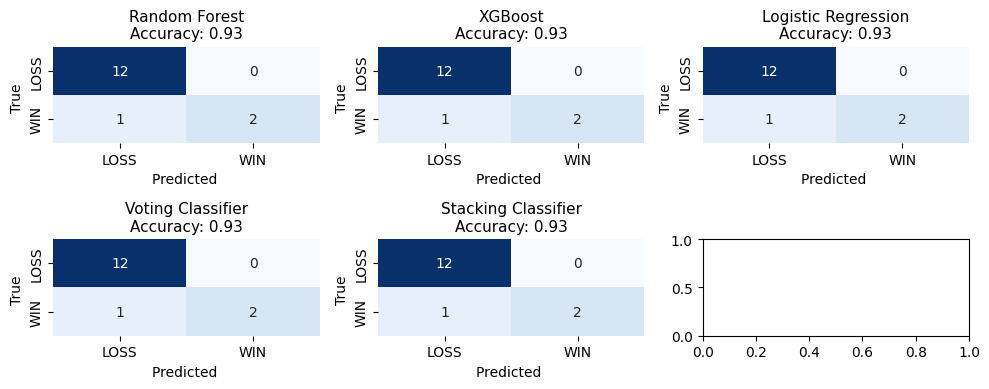

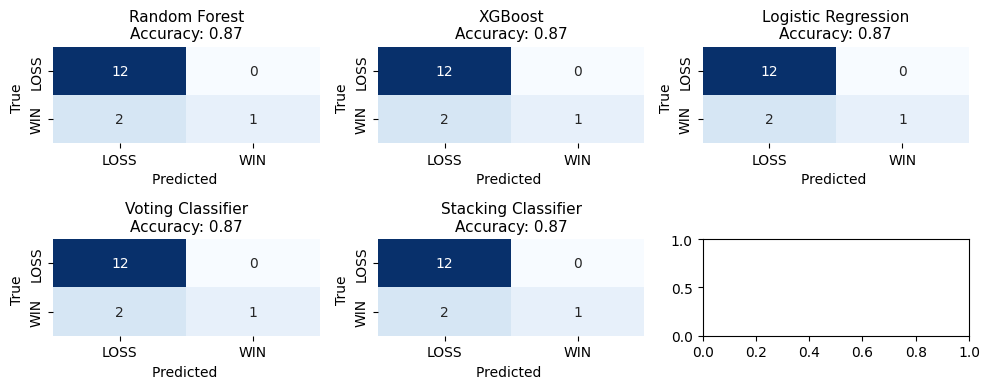

In [ ]:
regular_confusion_matrix = plot_confusion_matrices_horizontal(y_test_data, regular_binary_predictions, model_names, fig_size = (10,4))
# regular_multi_confusion_matrix = plot_confusion_matrices_horizontal(y_test_data_m, regular_multi_predictions, model_names,ticks = sorted(np.unique(y_test_data_m)),fig_size = (10,5))

old_confusion_matrix = plot_confusion_matrices_horizontal(y_test_data, old_binary_predictions, model_names, fig_size = (10,4))
# old_multi_confusion_matrix = plot_confusion_matrices_horizontal(y_test_data_m, old_multi_predictions, model_names,ticks = sorted(np.unique(y_test_data_m)),fig_size = (10,5))

In [ ]:
# print(new_regular_results[2]['Binary Predictions'])
# print(old_regular_results[2]['Binary Predictions'])
overall_stats(df, y_test_data, new_regular_results)

,Model,Total Trades,Total Win Count,Total Loss Count,Total Profit,Total Loss,Total Fee,Win Rate (%),Average R,Max Profit,Average Profit,Average Loss,Total Time (hours),Average Time (hours),Realized Profit/Loss,R
0,Random Forest(0.93),2,2,0,380.0,0.0,25.041494,100.0,3.8,188.49,177.48,0,7.0,3.5,354.96,15.17
1,XGBoost(0.93),2,2,0,380.0,0.0,25.041494,100.0,3.8,188.49,177.48,0,7.0,3.5,354.96,15.17
2,Logistic Regression(0.93),2,2,0,380.0,0.0,25.041494,100.0,3.8,188.49,177.48,0,7.0,3.5,354.96,15.17
3,Voting Classifier(0.93),2,2,0,380.0,0.0,25.041494,100.0,3.8,188.49,177.48,0,7.0,3.5,354.96,15.17
4,Stacking Classifier(0.93),2,2,0,380.0,0.0,25.041494,100.0,3.8,188.49,177.48,0,7.0,3.5,354.96,15.17


In [ ]:
overall_stats(df, y_test_data, old_regular_results)

,Model,Total Trades,Total Win Count,Total Loss Count,Total Profit,Total Loss,Total Fee,Win Rate (%),Average R,Max Profit,Average Profit,Average Loss,Total Time (hours),Average Time (hours),Realized Profit/Loss,R
0,Random Forest(0.87),1,1,0,180.0,0.0,13.527857,100.0,3.6,166.47,166.47,0,3.0,3.0,166.47,13.31
1,XGBoost(0.87),1,1,0,180.0,0.0,13.527857,100.0,3.6,166.47,166.47,0,3.0,3.0,166.47,13.31
2,Logistic Regression(0.87),1,1,0,180.0,0.0,13.527857,100.0,3.6,166.47,166.47,0,3.0,3.0,166.47,13.31
3,Voting Classifier(0.87),1,1,0,180.0,0.0,13.527857,100.0,3.6,166.47,166.47,0,3.0,3.0,166.47,13.31
4,Stacking Classifier(0.87),1,1,0,180.0,0.0,13.527857,100.0,3.6,166.47,166.47,0,3.0,3.0,166.47,13.31


##Show each trade result

In [ ]:
# start_index = 3107
# end_index = 3123
new_data = {
    'model_keys': model_keys,
    'model_names': model_names,
    'model_names_max_r': model_names_max_r,
    'training_feature_cols': training_feature_cols,
    'regular_binary_models': regular_binary_models,
    'regular_multi_models': regular_multi_models,
    'max_r_binary_models': max_r_binary_models,
    'max_r_multi_models': max_r_multi_models,
    'regular_accuracies': regular_accuracies,
    'max_r_accuracies': max_r_accuracies,
    'precomputed_stats': precomputed_stats,
    'precomputed_stats_max_r': precomputed_stats_max_r,
    'label_encoder': label_encoder,
    'label_encoder_max_r': label_encoder_max_r,
}

old_data = {
    'model_keys': model_keys,
    'model_names': model_names,
    'model_names_max_r': model_names_max_r,
    'training_feature_cols': old_training_feature_cols,
    'regular_binary_models': old_regular_binary_models,
    'regular_multi_models': old_regular_multi_models,
    'max_r_binary_models': old_max_r_binary_models,
    'max_r_multi_models': old_max_r_multi_models,
    'regular_accuracies': old_regular_accuracies,
    'max_r_accuracies': old_max_r_accuracies,
    'precomputed_stats': old_precomputed_stats,
    'precomputed_stats_max_r': old_precomputed_stats_max_r,
    'label_encoder': old_label_encoder,
    'label_encoder_max_r': old_label_encoder_max_r,
}

temp_data = {
    'model_keys': model_keys,
    'model_names': model_names,
    'model_names_max_r': model_names_max_r,
    'training_feature_cols':  temp_training_feature_cols,
    'regular_binary_models': temp_regular_binary_models,
    'regular_multi_models': temp_regular_multi_models,
    'max_r_binary_models': temp_max_r_binary_models,
    'max_r_multi_models': temp_max_r_multi_models,
    'regular_accuracies': temp_regular_accuracies,
    'max_r_accuracies': temp_max_r_accuracies,
    'precomputed_stats': temp_precomputed_stats,
    'precomputed_stats_max_r': temp_precomputed_stats_max_r,
    'label_encoder': temp_label_encoder,
    'label_encoder_max_r': temp_label_encoder_max_r,
}

prediction_summary_df = process_excel_and_predict(df_main, new_data, old_data, start_index-1, end_index-1)


--- Processing rows from index 3118 to 3132 ---

--- Predicting for Row Index: 3118 ---
Date: 07/03/2025, Time: 17:15, Criteria: PDHC, Prior CL: 0, Prior CW: 1

--- Predicting for Row Index: 3119 ---
Date: 07/03/2025, Time: 21:15, Criteria: LG RGC UPF, Prior CL: 0, Prior CW: 2

--- Predicting for Row Index: 3120 ---
Date: 07/03/2025, Time: 21:30, Criteria: LG RGC, Prior CL: 1, Prior CW: 0

--- Predicting for Row Index: 3121 ---
Date: 07/04/2025, Time: 02:15, Criteria: LG SBPS, Prior CL: 0, Prior CW: 1

--- Predicting for Row Index: 3122 ---
Date: 07/04/2025, Time: 03:00, Criteria: ELC, Prior CL: 1, Prior CW: 0

--- Predicting for Row Index: 3123 ---
Date: 07/04/2025, Time: 04:15, Criteria: LG PWH, Prior CL: 2, Prior CW: 0

--- Predicting for Row Index: 3124 ---
Date: 07/04/2025, Time: 04:45, Criteria: LG PDH, Prior CL: 3, Prior CW: 0

--- Predicting for Row Index: 3125 ---
Date: 07/04/2025, Time: 05:30, Criteria: LG RGC UPF, Prior CL: 4, Prior CW: 0

--- Predicting for Row Index: 3126

In [ ]:
prediction_summary_df

,Index,Date,Time,Criteria,CL,CW,Actual_R,RC-BD,RWC-B,O-C-BD,...,RC-MD,RWC-M,B_Pred,M_Pred,O_B_Pred,O_M_Pred,MR_B_Pred,MR_M_Pred,M-C-MD,M-WC-M
0,3119,07/03/2025,17:15,PDHC,0,1,W,Win,5,Win,...,Win,5,"[1, 1, 1, 1, 1]","[3, 3, 3, 3, 3]","[1, 1, 1, 1, 1]","[1, 1, 3, 1, 3]","[1, 1, 1, 1, 1]","[5, 7, 3, 3, 5]",Win,5
1,3120,07/03/2025,21:15,LG RGC UPF,0,2,L,Loss,0,Loss,...,Win,5,"[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]",Win,5
2,3121,07/03/2025,21:30,LG RGC,1,0,W,Win,5,Loss,...,Win,5,"[1, 1, 1, 1, 1]","[1, 3, 3, 3, 3]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]","[1, 3, 3, 3, 3]",Win,5
3,3122,07/04/2025,02:15,LG SBPS,0,1,L,Loss,0,Loss,...,Win,5,"[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]",Win,5
4,3123,07/04/2025,03:00,ELC,1,0,L,Loss,0,Loss,...,Win,5,"[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]",Win,5
5,3124,07/04/2025,04:15,LG PWH,2,0,L,Loss,0,Loss,...,Win,5,"[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]",Win,5
6,3125,07/04/2025,04:45,LG PDH,3,0,L,Loss,0,Loss,...,Win,5,"[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]",Win,5
7,3126,07/04/2025,05:30,LG RGC UPF,4,0,L,Loss,0,Loss,...,Win,5,"[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]",Win,5
8,3127,07/04/2025,06:30,LG BPS,5,0,L,Loss,0,Loss,...,Win,5,"[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]",Win,5
9,3128,07/04/2025,07:30,LG PDL,6,0,L,Loss,0,Loss,...,Win,5,"[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]",Win,5


In [ ]:
input_date_comb = "7/04/2025"  #@param {type:"string"}
start_time = '13:30' #@param {type:"string"}
end_time = '16:00' #@param {type:"string"}
input_CL_comb = 3 #@param {type:"integer"}
input_CW_comb = 0 #@param {type:"integer"}

input_date_comb = datetime.strptime(input_date_comb, '%m/%d/%Y').strftime('%m/%d/%Y')

time_values = [(datetime.strptime(start_time, "%H:%M") + timedelta(minutes=15*i)).strftime("%H:%M") for i in range(((datetime.strptime(end_time, "%H:%M") - datetime.strptime(start_time, "%H:%M")) // timedelta(minutes=15)) + 1)]
criteria_values=None

prediction_combinations_df = predict_for_combinations(
    input_date_comb,
    input_CL_comb,
    input_CW_comb,
    old_training_feature_cols,
    old_regular_binary_models,
    model_keys,
    model_names,
    old_precomputed_stats,
    criteria_values,
    time_values=time_values
)

# print("\n--- Sum of Binary Predictions for all Time/Criteria Combinations ---")
# print(prediction_combinations_df.head()) # Show first few rows



Unique Criteria: ['3FC', 'BTWT', 'DLTPS', 'DTLT', 'EL', 'EL HL', 'EL LL', 'EL SBPS', 'EL SPS', 'ELBPS', 'ELC', 'ELCI', 'ELUP', 'ELUPF', 'ELUPR', 'ElC', 'LG BPS', 'LG C', 'LG DTLPS', 'LG EL', 'LG ELC', 'LG IPS', 'LG LH', 'LG LL', 'LG PDH', 'LG PDL', 'LG PMH', 'LG PML', 'LG PS', 'LG PWH', 'LG PWL', 'LG RGC', 'LG RGC UP', 'LG RGC UPF', 'LG RGCR', 'LG SBPS', 'LG SHL', 'LG SLH', 'LG SPS', 'LGG EL', 'LGG PDH', 'LGG PWL', 'LW', 'PDHC', 'PDHC + LG PDH', 'PDLC', 'PDLC + LG PDL', 'PMHC', 'PMLC', 'PWHC', 'PWHC + LG PWH', 'PWLC', 'TPWL', 'UTLT', 'lG RGC']
Unique 15Min: ['13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00']
processsing.........: 13:30


/tmp/ipython-input-12-953411638.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


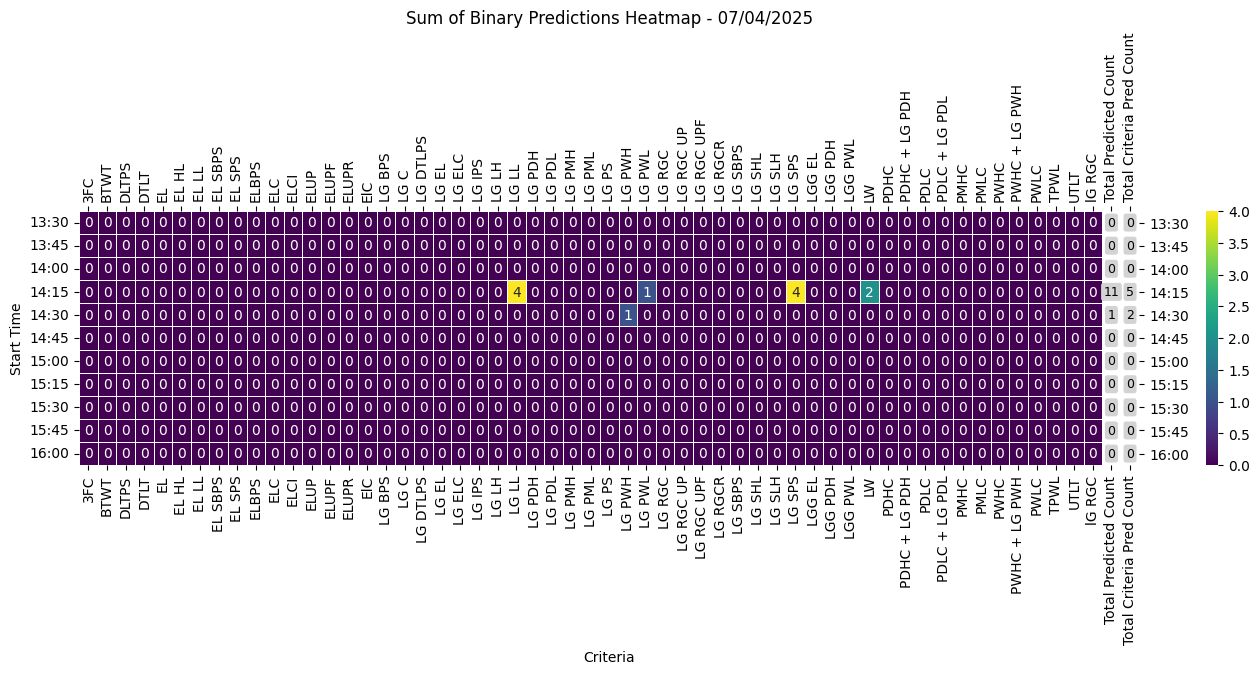

In [ ]:
heatmap_data=plot_prediction_heatmap(prediction_combinations_df, input_date_comb, invert=True, interactive=False)

In [ ]:
def predict_trading(time_input, date_input, criteria_input, CL, CW):
    # NEW MODELS
    new_summary, new_table, new_headers = show_predictions(
        time_input, date_input, criteria_input, CL, CW,
        training_feature_cols, model_names, model_keys,
        precomputed_stats=precomputed_stats,
        label_encoder=label_encoder,
        b_models=regular_binary_models,
        m_models=regular_multi_models,
        b_acc=regular_accuracies['Binary Accuracy'],
        m_acc=regular_accuracies['Multi-Class (R Bucket) Accuracy'],
        w_threshold=1, s_print=False, gradio=True
    )

    # OLD MODELS
    old_summary, old_table, old_headers = show_predictions(
        time_input, date_input, criteria_input, CL, CW,
        training_feature_cols, model_names, model_keys,
        precomputed_stats=old_precomputed_stats,
        label_encoder=old_label_encoder,
        b_models=old_regular_binary_models,
        m_models=old_regular_multi_models,
        b_acc=old_regular_accuracies['Binary Accuracy'],
        m_acc=old_regular_accuracies['Multi-Class (R Bucket) Accuracy'],
        w_threshold=1, s_print=False, gradio=True
    )

    # TEST MODELS
    test_summary, test_table, test_headers = show_predictions(
        time_input, date_input, criteria_input, CL, CW,
        training_feature_cols, model_names, model_keys,
        precomputed_stats=temp_precomputed_stats,
        label_encoder=temp_label_encoder,
        b_models=temp_regular_binary_models,
        m_models=temp_regular_multi_models,
        b_acc=temp_regular_accuracies['Binary Accuracy'],
        m_acc=temp_regular_accuracies['Multi-Class (R Bucket) Accuracy'],
        w_threshold=1, s_print=False, gradio=True
    )

    return (
        new_summary, pd.DataFrame(new_table, columns=new_headers),
        old_summary, pd.DataFrame(old_table, columns=old_headers),
        test_summary, pd.DataFrame(test_table, columns=test_headers)
    )


In [ ]:
now = datetime.now(timezone.utc)
minute = (now.minute // 15) * 15
current_time = now.replace(minute=minute, second=0, microsecond=0).strftime('%H:%M')
current_date = now.strftime('%m/%d/%Y')

criteria_options = regular_unique_criteria

# Time options (suggestions)
time_options = [f"{h:02d}:{m:02d}" for h in range(24) for m in (0, 15, 30, 45)]

In [ ]:
import gradio as gr

app = gr.Interface(
    fn=predict_trading,
    inputs=[
        gr.Dropdown(label="Time (HH:MM)", choices=time_options, value=current_time, allow_custom_value=True),
        gr.Textbox(label="Date (MM/DD/YYYY)", value=current_date),
        gr.Dropdown(label="Criteria", choices=criteria_options, allow_custom_value=True, value="LG RGC"),
        gr.Number(label="CL"),
        gr.Number(label="CW"),
    ],
    outputs=[
        gr.Textbox(label="📘 New Model Summary"),
        gr.Dataframe(label="New Model Predictions"),

        gr.Textbox(label="📙 Old Model Summary"),
        gr.Dataframe(label="Old Model Predictions"),

        gr.Textbox(label="📗 Test Model Summary"),
        gr.Dataframe(label="Test Model Predictions"),
    ],
    title="📈 Multi-Model Trade Prediction Dashboard",
    description="Compare New, Old, and Test models for a given input scenario. Default time and date are auto-filled."
)

app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://edadd6d91c19e6d2de.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
